In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Initialize some global variables
BATCH_SIZE = 1000
STEP_SIZE = 5
EPOCHS = 15
LAMBDA = 0.0001
DATA_ROOT = './data/mnist'
MODEL_NAME = ['mnist_1', 'mnist_2']

# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("The current PyTorch install was not built with MPS enabled.")
    else:
        print("The current MacOS version is not 12.3+ and/or you do not have an"
              " MPS-enabled device on this machine.")
    DEVICE = torch.device("cpu")
else:
    DEVICE = torch.device("mps")
    print("MPS is available now.")

MPS is available now.


In [34]:
class Reshape(object):
    '''A custom transform to reshape input data'''

    def __init__(self):
        pass

    def __call__(self, img):
        return img.view(1, -1)


def load_data_mnist(batch_size: 'int' = 1000,
                    data_root: 'str' = './data/mnist'):
    '''Create training, validation and test dataloader'''

    # Specify mean and std of dataset
    mean = (0.1307, )
    std = (0.3081, )

    # Construct transforms
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean, std),
         Reshape()])

    # Acquire training and test datasets.
    train_dataset = datasets.MNIST(root=data_root,
                                   train=True,
                                   download=True,
                                   transform=transform)
    test_dataset = datasets.MNIST(root=data_root,
                                  train=False,
                                  download=True,
                                  transform=transform)

    # Use 20% of training data for validation.
    train_dataset_size = int(len(train_dataset) * 0.8)
    valid_dataset_size = len(train_dataset) - train_dataset_size

    seed = torch.Generator().manual_seed(42)
    train_set, valid_set = torch.utils.data.random_split(
        train_dataset, [train_dataset_size, valid_dataset_size],
        generator=seed)

    # Construct data loader for training, validation and test sets.
    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch_size,
                                               shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set,
                                               batch_size=batch_size,
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

    return train_loader, valid_loader, test_loader, mean, std

In [35]:
def exsamples_vis(dataloader,
                  geo_subplots: 'tuple' = (4, 7),
                  figsize: 'tuple' = (7, 6),
                  **kwargs):
    '''Visualize some exsamples of MNIST'''

    try:
        mean = kwargs['mean']
        std = kwargs['std']
        unnormal = True
        print(f"Input data will be unnormalized.")
    except KeyError:
        unnormal = False
        print(f"Input data will be normalized.")

    exsamples = iter(dataloader)
    images, labels = next(exsamples)
    images = images.numpy()
    labels = labels.numpy()

    _, ax = plt.subplots(geo_subplots[0],
                         geo_subplots[1],
                         sharey=True,
                         figsize=figsize)
    ax = ax.ravel()
    for i in range(np.prod(geo_subplots)):
        if unnormal:
            # Unnormalize
            img = images[i] * std + mean
        else:
            img = images[i]

        # Reshape the input data
        img = img.reshape([28, 28])
        # Make sure the intensity stays in range of [0, 255]
        img = (img * 255).astype(np.uint8)
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(f"Label: {labels[i]}")

    plt.show()

In [36]:
def training_model(model,
                   optimizer,
                   criterion,
                   device,
                   epochs: 'int',
                   training: 'bool' = True,
                   regulization: 'bool' = False,
                   **kwargs):
    '''Define a training (and testing) process.'''

    if training:
        train_loader = kwargs['train_loader']
        valid_loader = kwargs['valid_loader']
        model_name = kwargs['model_name']
    else:
        train_loader = None
        model_name = None
        valid_loader = kwargs['test_loader']

    if regulization:
        lam = kwargs['lam']
    else:
        lam = 0.0

    # Record loss and accuracy
    training_loss = []
    validation_loss = []
    training_acc = []
    validation_acc = []

    for epoch in range(epochs):

        if training:
            print(f"Epoch {epoch+1}: Start training.")

            # Keep track of training loss and training accuracy
            tr_loss, tr_acc = 0.0, 0.0
            model.train()
            for (data, label) in train_loader:
                data, label = torch.squeeze(data).to(device), label.to(device)

                optimizer.zero_grad()
                tr_output = model(data)
                loss = criterion(tr_output, label)

                if regulization:
                    # Add a regularization term
                    w_1 = list(model.parameters())[0]
                    w_2 = list(model.parameters())[1]
                    loss = loss + lam * (torch.linalg.norm(w_1)**2 +
                                         torch.linalg.norm(w_2)**2)

                loss.backward()
                optimizer.step()

                tr_loss += loss.item() * data.size(0)
                tr_acc += mnist_accuracy(tr_output, label, device)

            # Record training loss.
            training_loss.append(tr_loss / len(train_loader.dataset))
            training_acc.append(tr_acc / len(train_loader.dataset))

        with torch.no_grad():
            if training:
                print(f"Epoch {epoch+1}: Start validating.")
            else:
                print(f"Epoch {epoch+1}: Start testing.")

            # Keep track of validation loss and validation accuracy
            val_loss, val_acc = 0.0, 0.0

            # Compute and record validation loss and validation set accuracy
            model.eval()
            for (data, label) in valid_loader:
                data, label = torch.squeeze(data).to(device), label.to(device)
                val_output = model(data)
                loss = criterion(val_output, label)
                val_loss += loss.item() * data.size(0)
                val_acc += mnist_accuracy(val_output, label, device)

            validation_loss.append(val_loss / len(valid_loader.dataset))
            validation_acc.append(val_acc / len(valid_loader.dataset))

            if training:
                if early_stopping(validation_loss):
                    torch.save(model.state_dict(),
                               f'./outputs/{model_name}.pt')
                    break
                elif epoch == epochs - 1:
                    torch.save(model.state_dict(),
                               f'./outputs/{model_name}.pt')
                    print(f"Early stopping is not implemented!")

    return [training_loss, validation_loss, training_acc, validation_acc]


def mnist_accuracy(output, label, device):
    '''Compute accuracy for MNIST.'''

    with torch.no_grad():
        # Compute and record training set accuracy
        pred = F.softmax(output - torch.max(output), dim=1)
        correct = torch.sum(torch.argmax(pred, dim=1) == label)
        correct = correct.detach().cpu().numpy(
        ) if device.type == 'mps' else correct.detach().numpy()
        return correct


def early_stopping(val_loss: 'list', error: 'float' = 0.1):
    '''Stop training if validation loss has increased.'''

    if val_loss[-1] - min(val_loss) >= error:
        print(f"Validation loss starts increasing, training will stop.")
        return True
    else:
        return False

In [37]:
class Model_MNIST(nn.Module):
    '''Define an exsample model with standard normalized weights for MNIST'''

    def __init__(self, input_dim, output_dim, units_dim):
        super().__init__()
        np.random.seed(0)
        self.weight_1 = nn.Parameter(
            torch.tensor(np.random.standard_normal((units_dim, input_dim)),
                         dtype=torch.float32))
        self.weight_2 = nn.Parameter(
            torch.tensor(np.random.standard_normal((output_dim, units_dim)),
                         dtype=torch.float32))
        self.bias_1 = nn.Parameter(
            torch.tensor(np.zeros((units_dim)), dtype=torch.float32))
        self.bias_2 = nn.Parameter(
            torch.tensor(np.zeros((output_dim)), dtype=torch.float32))

    def forward(self, x):
        # Layer 1
        x = nn.functional.linear(x, self.weight_1, self.bias_1)
        x = torch.sigmoid(x)
        # Layer 2
        x = nn.functional.linear(x, self.weight_2, self.bias_2)
        return x

Input data will be unnormalized.


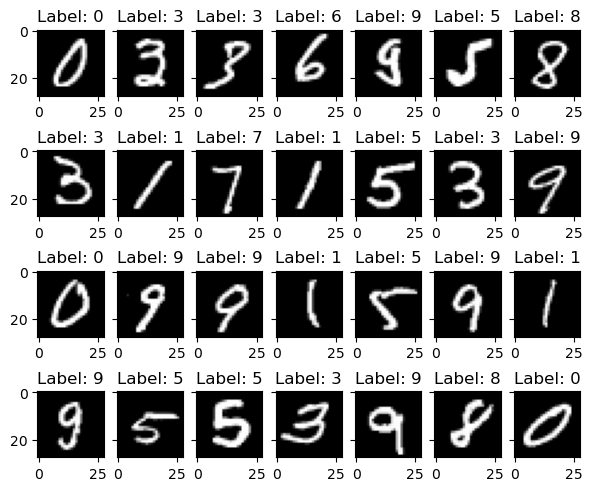

In [38]:
# Create training, validation and test dataloader
tr_loader, val_loader, te_loader, mean, std = load_data_mnist(
    BATCH_SIZE, DATA_ROOT)

# Visualize some exsamples
exsamples_vis(tr_loader,
              geo_subplots=(4, 7),
              figsize=(7, 6),
              mean=mean,
              std=std)


In [39]:
# Training model without regulization
print(f"Training model without regulization.")
model_mnist = Model_MNIST(784, 10, 300).to(DEVICE)
optimizer = torch.optim.SGD(model_mnist.parameters(), lr=STEP_SIZE)
#optimizer = torch.optim.Adam(model_mnist.parameters(), lr=0.1, betas=(0.9, 0.999))
criterion = torch.nn.CrossEntropyLoss()

results_1 = training_model(model_mnist,
                           optimizer,
                           criterion,
                           DEVICE,
                           model_name=MODEL_NAME[0],
                           epochs=EPOCHS,
                           training=True,
                           train_loader=tr_loader,
                           valid_loader=val_loader)

# Training model 2
print(f"Training model with regulization.")
model_mnist = Model_MNIST(784, 10, 300).to(DEVICE)
optimizer = torch.optim.SGD(model_mnist.parameters(), lr=STEP_SIZE)
#optimizer = torch.optim.Adam(model_mnist.parameters())
criterion = torch.nn.CrossEntropyLoss()

results_2 = training_model(model_mnist,
                           optimizer,
                           criterion,
                           DEVICE,
                           model_name=MODEL_NAME[1],
                           epochs=EPOCHS,
                           training=True,
                           regulization=True,
                           lam=LAMBDA,
                           train_loader=tr_loader,
                           valid_loader=val_loader)


Training model without regulization.
Epoch 1: Start training.
Epoch 1: Start validating.
Epoch 2: Start training.
Epoch 2: Start validating.
Epoch 3: Start training.
Epoch 3: Start validating.
Epoch 4: Start training.
Epoch 4: Start validating.
Epoch 5: Start training.
Epoch 5: Start validating.
Epoch 6: Start training.
Epoch 6: Start validating.
Epoch 7: Start training.
Epoch 7: Start validating.
Epoch 8: Start training.
Epoch 8: Start validating.
Epoch 9: Start training.
Epoch 9: Start validating.
Epoch 10: Start training.
Epoch 10: Start validating.
Epoch 11: Start training.
Epoch 11: Start validating.
Epoch 12: Start training.
Epoch 12: Start validating.
Epoch 13: Start training.
Epoch 13: Start validating.
Epoch 14: Start training.
Epoch 14: Start validating.
Epoch 15: Start training.
Epoch 15: Start validating.
Early stopping is not implemented!
Training model with regulization.
Epoch 1: Start training.
Epoch 1: Start validating.
Epoch 2: Start training.
Epoch 2: Start validating

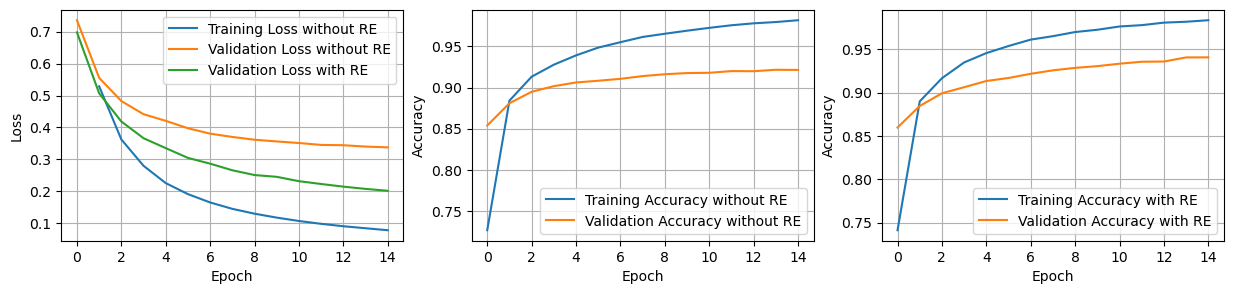

In [40]:
# Visualize validation results
_, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].plot(results_1[0], label='Training Loss without RE')
ax[0].plot(results_1[1], label='Validation Loss without RE')
ax[0].plot(results_2[1], label='Validation Loss with RE')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid()
ax[0].legend()

ax[1].plot(results_1[2], label='Training Accuracy without RE')
ax[1].plot(results_1[3], label='Validation Accuracy without RE')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].grid()
ax[1].legend()

ax[2].plot(results_2[2], label='Training Accuracy with RE')
ax[2].plot(results_2[3], label='Validation Accuracy with RE')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].grid()
ax[2].legend()
plt.show()

In [41]:
# Testing model 1
print(f"Testing model without regulization.")
model_mnist.load_state_dict(torch.load(f'./outputs/{MODEL_NAME[0]}.pt'))
optimizer = torch.optim.SGD(model_mnist.parameters(), lr=STEP_SIZE)
#optimizer = torch.optim.Adam(model_mnist.parameters(), lr=0.1, betas=(0.9, 0.999))
criterion = torch.nn.CrossEntropyLoss()

results_1 = training_model(model_mnist,
                           optimizer,
                           criterion,
                           DEVICE,
                           epochs=EPOCHS,
                           training=False,
                           test_loader=te_loader)

# Testing model 2
print(f"Testing model with regulization.")
model_mnist.load_state_dict(torch.load(f'./outputs/{MODEL_NAME[1]}.pt'))
optimizer = torch.optim.SGD(model_mnist.parameters(), lr=STEP_SIZE)
# optimizer = torch.optim.Adam(model_mnist.parameters(), lr=0.1, betas=(0.9, 0.999))
criterion = torch.nn.CrossEntropyLoss()

results_2 = training_model(model_mnist,
                           optimizer,
                           criterion,
                           DEVICE,
                           epochs=EPOCHS,
                           training=False,
                           regulization=True,
                           lam=LAMBDA,
                           test_loader=te_loader)

# Show test results
best_acc_1 = round(max(results_1[3]) * 100, 2)
best_acc_2 = round(max(results_2[3]) * 100, 2)
print(f"The best accuracy on the test set without regulization:"
      f" {best_acc_1}%")
print(f"The best accuracy on the test set with regulization:"
      f" {best_acc_2}%")


Testing model without regulization.
Epoch 1: Start testing.
Epoch 2: Start testing.
Epoch 3: Start testing.
Epoch 4: Start testing.
Epoch 5: Start testing.
Epoch 6: Start testing.
Epoch 7: Start testing.
Epoch 8: Start testing.
Epoch 9: Start testing.
Epoch 10: Start testing.
Epoch 11: Start testing.
Epoch 12: Start testing.
Epoch 13: Start testing.
Epoch 14: Start testing.
Epoch 15: Start testing.
Testing model with regulization.
Epoch 1: Start testing.
Epoch 2: Start testing.
Epoch 3: Start testing.
Epoch 4: Start testing.
Epoch 5: Start testing.
Epoch 6: Start testing.
Epoch 7: Start testing.
Epoch 8: Start testing.
Epoch 9: Start testing.
Epoch 10: Start testing.
Epoch 11: Start testing.
Epoch 12: Start testing.
Epoch 13: Start testing.
Epoch 14: Start testing.
Epoch 15: Start testing.
The best accuracy on the test set without regulization: 92.63%
The best accuracy on the test set with regulization: 94.52%
